# Introduction Opening a new restaurant in New York city

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Sol

# Download Data

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
#newyork_data    

In [4]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# Then let's loop through the data and fill the dataframe one row at a time.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [7]:
# add colom restaurants
neighborhoods['restaurants'] = 00000000
neighborhoods.head(7)


,Borough,Neighborhood,Latitude,Longitude,restaurants
0,Bronx,Wakefield,40.894705,-73.847201,0
1,Bronx,Co-op City,40.874294,-73.829939,0
2,Bronx,Eastchester,40.887556,-73.827806,0
3,Bronx,Fieldston,40.895437,-73.905643,0
4,Bronx,Riverdale,40.890834,-73.912585,0
5,Bronx,Kingsbridge,40.881687,-73.902818,0
6,Manhattan,Marble Hill,40.876551,-73.910660,0


In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [12]:
manhattan_data = neighborhoods.copy()
#manhattan_data.head()

In [13]:
import folium
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Borough'], manhattan_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [30]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['id'], 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'id', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

# Define Foursquare Credentials and Version

In [57]:
LIMIT = 500 
radius = 10000 
CLIENT_ID = 'BPRDGUIQFF4E2EOXUVNWN5FUTXNKKKMV1YYTJSHVBOCX3DRU'
CLIENT_SECRET = '2ESSUXJSR4RIJYIWEUHYCHN4JTTFV0ECVSJY35QSL4DM1JZN'
VERSION = '20181020'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BPRDGUIQFF4E2EOXUVNWN5FUTXNKKKMV1YYTJSHVBOCX3DRU
CLIENT_SECRET:2ESSUXJSR4RIJYIWEUHYCHN4JTTFV0ECVSJY35QSL4DM1JZN


In [58]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude,restaurants
0,Bronx,Wakefield,40.894705,-73.847201,0
1,Bronx,Co-op City,40.874294,-73.829939,0
2,Bronx,Eastchester,40.887556,-73.827806,0
3,Bronx,Fieldston,40.895437,-73.905643,0
4,Bronx,Riverdale,40.890834,-73.912585,0


In [51]:
# try
s100 = neighborhoods.groupby(['Borough']).size().reset_index(name='counts')
s100.head()


,Borough,counts
0,Bronx,52
1,Brooklyn,70
2,Manhattan,40
3,Queens,81
4,Staten Island,63


In [80]:
#https://developer.foursquare.com/docs/resources/categories
#Italian Restaurant 4bf58dd8d48988d110941735
#neighborhoods = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d110941735')
newyork_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,4c858c5d51ada1cd1f103910,Frank and Johnies,40.905019,-73.858392,Italian Restaurant
1,Co-op City,40.874294,-73.829939,5411894d498e4a254a11a46c,Olive Garden,40.864483,-73.827894,Italian Restaurant
2,Fieldston,40.895437,-73.905643,4c6994e3c946e21eb28eea8e,Salvatore's of Soho,40.887633,-73.907178,Pizza Place
3,Fieldston,40.895437,-73.905643,56787589498eca7da2a82944,Caffe Buon Gusto - Bronx,40.889477,-73.899558,Italian Restaurant
4,Riverdale,40.890834,-73.912585,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,40.886595,-73.909556,Italian Restaurant


In [81]:
newyork_venues.shape

(2861, 8)

In [114]:
# group by id and delete 
newyork_venues = newyork_venues.drop_duplicates(subset=['id'], keep=False)
newyork_venues.shape


(648, 8)

In [115]:
newyork_venues = newyork_venues.rename(columns={'Neighborhood Latitude': 'Latitude', 'Neighborhood Longitude': 'Longitude'})


In [116]:
manhattan_data = newyork_venues.copy()
#manhattan_data = neighborhoods.copy()

# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [117]:
re0_venues = newyork_venues.groupby(['Neighborhood']).size().reset_index(name='counts')
re0_venues.head()


,Neighborhood,counts
0,Annadale,1
1,Arden Heights,1
2,Arlington,1
3,Arrochar,1
4,Astoria,8


# combine re0_venues with neighborhoods

In [118]:
neighborhoods.restaurants = 0
res_neighborhoods = neighborhoods.copy()
res_neighborhoods['restaurants'] = res_neighborhoods['Neighborhood'].map(re0_venues.set_index('Neighborhood')['counts'])
res_neighborhoods['restaurants'].fillna(0, inplace=True)
res_neighborhoods['restaurants'] = res_neighborhoods['restaurants'].astype(int)
res_neighborhoods.head(20)

,Borough,Neighborhood,Latitude,Longitude,restaurants
0,Bronx,Wakefield,40.894705,-73.847201,1
1,Bronx,Co-op City,40.874294,-73.829939,0
2,Bronx,Eastchester,40.887556,-73.827806,0
3,Bronx,Fieldston,40.895437,-73.905643,0
4,Bronx,Riverdale,40.890834,-73.912585,0
5,Bronx,Kingsbridge,40.881687,-73.902818,1
6,Manhattan,Marble Hill,40.876551,-73.910660,0
7,Bronx,Woodlawn,40.898273,-73.867315,2
8,Bronx,Norwood,40.877224,-73.879391,1
9,Bronx,Williamsbridge,40.881039,-73.857446,0


In [93]:
# save dataframe in file .csv
#res_neighborhoods.to_csv(r'data_33.csv', index=False)
res_neighborhoods.to_csv(r'data_33.csv')


In [94]:
# read dataframe from file .csv
res_neighborhoods = pd.read_csv('data_33.csv', index_col=[0])
res_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude,restaurants
0,Bronx,Wakefield,40.894705,-73.847201,1
1,Bronx,Co-op City,40.874294,-73.829939,0
2,Bronx,Eastchester,40.887556,-73.827806,0
3,Bronx,Fieldston,40.895437,-73.905643,0
4,Bronx,Riverdale,40.890834,-73.912585,0


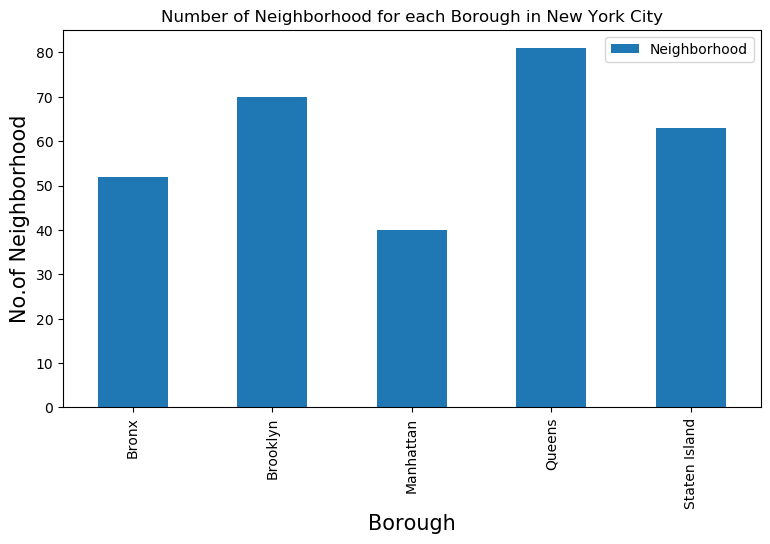

In [119]:
new_york_data = res_neighborhoods.copy()

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [121]:
# read dataframe from file .csv
#df2 = pd.read_csv('data_00.csv', index_col=None, header=0)
df2 = pd.read_csv('data_00.csv', index_col=[0])
df2


,Borough,Population,Gross Domestic Product,Land area,latitude,longitude
0,Brooklyn,2582830,91.559,70.82,40.650104,-73.949582
1,Manhattan,1628701,600.244,22.83,40.789624,-73.959894
2,Queens,2278906,93.310,108.53,40.749824,-73.797634
3,Staten Island,476179,14.514,58.37,40.583456,-74.149605
4,The Bronx,1432132,42.695,42.10,40.846651,-73.878594


In [122]:
re1_neighborhoods = res_neighborhoods.copy()
re1_neighborhoods['Gross Domestic Product'] = 000000.000
re1_neighborhoods['Population'] = 000000000
re1_neighborhoods.head()


,Borough,Neighborhood,Latitude,Longitude,restaurants,Gross Domestic Product,Population
0,Bronx,Wakefield,40.894705,-73.847201,1,0.0,0
1,Bronx,Co-op City,40.874294,-73.829939,0,0.0,0
2,Bronx,Eastchester,40.887556,-73.827806,0,0.0,0
3,Bronx,Fieldston,40.895437,-73.905643,0,0.0,0
4,Bronx,Riverdale,40.890834,-73.912585,0,0.0,0


In [123]:
# grup by Borough
df3 = re1_neighborhoods.groupby(['Borough']).size().reset_index(name='counts')
df3.head( 7)


,Borough,counts
0,Bronx,52
1,Brooklyn,70
2,Manhattan,40
3,Queens,81
4,Staten Island,63


In [124]:
# combine re1_neighborhoods with df2
df2.at[4,"Borough"] = re1_neighborhoods.at[0,"Borough"]

re1_neighborhoods['counts'] = re1_neighborhoods['Borough'].map(df3.set_index('Borough')['counts'])
re1_neighborhoods['Neighborhood'].fillna(0, inplace=True)

re1_neighborhoods['Gross Domestic Product'] = re1_neighborhoods['Borough'].map(df2.set_index('Borough')['Gross Domestic Product'])
re1_neighborhoods['Neighborhood'].fillna(0, inplace=True)

re1_neighborhoods['Population'] = re1_neighborhoods['Borough'].map(df2.set_index('Borough')['Population'])
re1_neighborhoods['Neighborhood'].fillna(0, inplace=True)
#re1_neighborhoods.head(20)

# calculated new field Rating
re1_neighborhoods['Rating'] = 000000.000

re1_neighborhoods.head(20)


,Borough,Neighborhood,Latitude,Longitude,restaurants,Gross Domestic Product,Population,counts,Rating
0,Bronx,Wakefield,40.894705,-73.847201,1,42.695,1432132,52,0.0
1,Bronx,Co-op City,40.874294,-73.829939,0,42.695,1432132,52,0.0
2,Bronx,Eastchester,40.887556,-73.827806,0,42.695,1432132,52,0.0
3,Bronx,Fieldston,40.895437,-73.905643,0,42.695,1432132,52,0.0
4,Bronx,Riverdale,40.890834,-73.912585,0,42.695,1432132,52,0.0
5,Bronx,Kingsbridge,40.881687,-73.902818,1,42.695,1432132,52,0.0
6,Manhattan,Marble Hill,40.876551,-73.910660,0,600.244,1628701,40,0.0
7,Bronx,Woodlawn,40.898273,-73.867315,2,42.695,1432132,52,0.0
8,Bronx,Norwood,40.877224,-73.879391,1,42.695,1432132,52,0.0
9,Bronx,Williamsbridge,40.881039,-73.857446,0,42.695,1432132,52,0.0


In [125]:
re2_venues = re1_neighborhoods.drop(re1_neighborhoods[re1_neighborhoods.restaurants < 1].index)
re2_venues = re2_venues.reset_index(drop=True)
re2_venues.head( )
#re2_venues.shape


,Borough,Neighborhood,Latitude,Longitude,restaurants,Gross Domestic Product,Population,counts,Rating
0,Bronx,Wakefield,40.894705,-73.847201,1,42.695,1432132,52,0.0
1,Bronx,Kingsbridge,40.881687,-73.902818,1,42.695,1432132,52,0.0
2,Bronx,Woodlawn,40.898273,-73.867315,2,42.695,1432132,52,0.0
3,Bronx,Norwood,40.877224,-73.879391,1,42.695,1432132,52,0.0
4,Bronx,Baychester,40.866858,-73.835798,1,42.695,1432132,52,0.0


In [127]:
re2_venues.shape

(172, 9)

In [154]:
df4 = re2_venues.groupby(['Borough'])['restaurants'].agg('sum').reset_index(name='counts')
df4.head( 7)


,Borough,counts
0,Bronx,33
1,Brooklyn,155
2,Manhattan,254
3,Queens,156
4,Staten Island,84


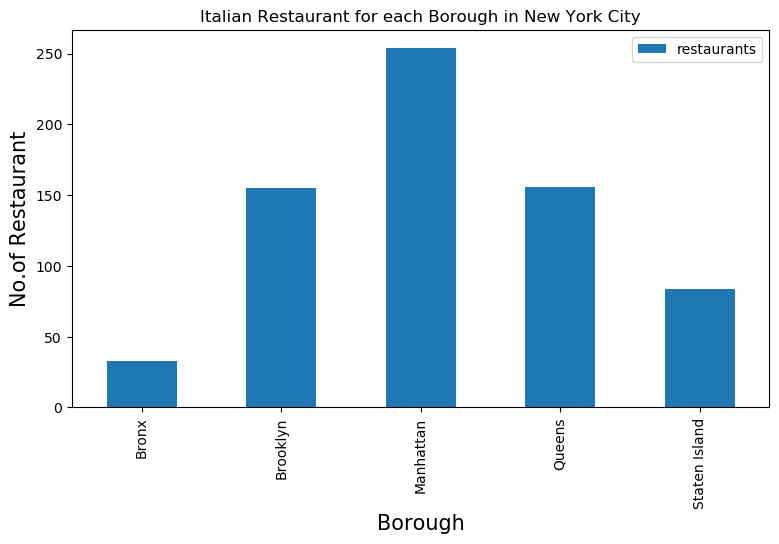

In [163]:
from pandas import DataFrame
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Italian Restaurant for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Restaurant', fontsize=15)
#giving a bar plot
re2_venues.groupby('Borough')['restaurants'].sum().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [164]:
df2

,Borough,Population,Gross Domestic Product,Land area,latitude,longitude
0,Brooklyn,2582830,91.559,70.82,40.650104,-73.949582
1,Manhattan,1628701,600.244,22.83,40.789624,-73.959894
2,Queens,2278906,93.310,108.53,40.749824,-73.797634
3,Staten Island,476179,14.514,58.37,40.583456,-74.149605
4,Bronx,1432132,42.695,42.10,40.846651,-73.878594


In [165]:
df5 = df2.copy()
df5['restaurants'] = 0000000
df5['Rating'] = 0000000
df5.head()

,Borough,Population,Gross Domestic Product,Land area,latitude,longitude,restaurants,Rating
0,Brooklyn,2582830,91.559,70.82,40.650104,-73.949582,0,0
1,Manhattan,1628701,600.244,22.83,40.789624,-73.959894,0,0
2,Queens,2278906,93.310,108.53,40.749824,-73.797634,0,0
3,Staten Island,476179,14.514,58.37,40.583456,-74.149605,0,0
4,Bronx,1432132,42.695,42.10,40.846651,-73.878594,0,0


In [166]:
df5['restaurants'] = df5['Borough'].map(df4.set_index('Borough')['counts'])
#re1_neighborhoods['Neighborhood'].fillna(0, inplace=True)
df5.head()

,Borough,Population,Gross Domestic Product,Land area,latitude,longitude,restaurants,Rating
0,Brooklyn,2582830,91.559,70.82,40.650104,-73.949582,155,0
1,Manhattan,1628701,600.244,22.83,40.789624,-73.959894,254,0
2,Queens,2278906,93.310,108.53,40.749824,-73.797634,156,0
3,Staten Island,476179,14.514,58.37,40.583456,-74.149605,84,0
4,Bronx,1432132,42.695,42.10,40.846651,-73.878594,33,0


In [167]:
df5['Rating'] = ( df5['Gross Domestic Product'] * df5['Population'] ) /df5['restaurants']
df5['Rating'] = df5['Rating'].astype(int)

df6 = df5.sort_values(by='Rating', ascending=False).reset_index()

df6.head( 20)


,index,Borough,Population,Gross Domestic Product,Land area,latitude,longitude,restaurants,Rating
0,1,Manhattan,1628701,600.244,22.83,40.789624,-73.959894,254,3848889
1,4,Bronx,1432132,42.695,42.10,40.846651,-73.878594,33,1852875
2,0,Brooklyn,2582830,91.559,70.82,40.650104,-73.949582,155,1525686
3,2,Queens,2278906,93.310,108.53,40.749824,-73.797634,156,1363107
4,3,Staten Island,476179,14.514,58.37,40.583456,-74.149605,84,82276
